<a href="https://colab.research.google.com/github/jljudge-gh/JupyterNotebooks-MathmaticalMethods-DataScience/blob/main/3_3_Unconstrained_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.3 Unconstrained Optimization

## Optimization in Python using [scipy](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)




### Unconstrained minimization of multivariate scalar functions (minimize)

The `minimize` function provides a common interface to unconstrained and constrained minimization algorithms for multivariate scalar functions in `scipy.optimize`. To demonstrate the minimization function, consider the problem of minimizing the Rosenbrock function of $N$ variables:

$$ f(\mathbf{x})=\sum_{i=1}^{N-1} 100\left(x_{i+1}-x_{i}^{2}\right)^{2}+\left(1-x_{i}\right)^{2} $$

The minimum value of this function is $0$ which is achieved when $x_i=1$.

Note that the Rosenbrock function and its derivatives are included in `scipy.optimize`. The implementations shown in the following sections provide examples of how to define an objective function as well as its jacobian and hessian functions.

#### Nelder-Mead Simplex algorithm (method='Nelder-Mead')

In the example below, the `minimize` routine is used with the *Nelder-Mead* simplex algorithm (selected through the `method` parameter):

In [1]:
import numpy as np
from scipy.optimize import minimize

In [2]:
def rosen(x):
    """The Rosenbrock function"""
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

In [3]:
x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
res = minimize(rosen, x0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 339
         Function evaluations: 571


In [4]:
print(res.x)

[1. 1. 1. 1. 1.]


The simplex algorithm is probably the simplest way to minimize a fairly well-behaved function. It requires only function evaluations and is a good choice for simple minimization problems. However, because it does not use any gradient evaluations, it may take longer to find the minimum.

Another optimization algorithm that needs only function calls to find the minimum is *Powell’s* method available by setting `method='powell'` in `minimize`.

#### Broyden-Fletcher-Goldfarb-Shanno algorithm (method='BFGS')

In order to converge more quickly to the solution, this routine uses the gradient of the objective function. If the gradient is not given by the user, then it is estimated using first-differences. The Broyden-Fletcher-Goldfarb-Shanno (BFGS) method typically requires fewer function calls than the simplex algorithm even when the gradient must be estimated.

To demonstrate this algorithm, the Rosenbrock function is again used. The gradient of the Rosenbrock function is the vector:



$$
\begin{aligned}
\frac{\partial f}{\partial x_{j}} &=\sum_{i=1}^{N} 200\left(x_{i}-x_{i-1}^{2}\right)\left(\delta_{i, j}-2 x_{i-1} \delta_{i-1, j}\right)-2\left(1-x_{i-1}\right) \delta_{i-1, j} \\
&=200\left(x_{j}-x_{j-1}^{2}\right)-400 x_{j}\left(x_{j+1}-x_{j}^{2}\right)-2\left(1-x_{j}\right)
\end{aligned}
$$

This expression is valid for the interior derivatives. Special cases are



$$
\begin{aligned}
\frac{\partial f}{\partial x_{0}} &=-400 x_{0}\left(x_{1}-x_{0}^{2}\right)-2\left(1-x_{0}\right) \\
\frac{\partial f}{\partial x_{N-1}} &=200\left(x_{N-1}-x_{N-2}^{2}\right)
\end{aligned}
$$

A Python function which computes this gradient is constructed by the code-segment:



In [5]:
def rosen_der(x):
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    der = np.zeros_like(x)
    der[1:-1] = 200*(xm-xm_m1**2) - 400*(xm_p1 - xm**2)*xm - 2*(1-xm)
    der[0] = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
    der[-1] = 200*(x[-1]-x[-2]**2)
    return der

This gradient information is specified in the `minimize` function through the jac parameter as illustrated below.



In [6]:
res = minimize(rosen, x0, method='BFGS', jac=rosen_der,
               options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 25
         Function evaluations: 30
         Gradient evaluations: 30


In [7]:
res.x

array([1.00000004, 1.0000001 , 1.00000021, 1.00000044, 1.00000092])

#### Newton-Conjugate-Gradient algorithm (method='Newton-CG')

Newton-Conjugate Gradient algorithm is a modified Newton’s method and uses a conjugate gradient algorithm to (approximately) invert the local Hessian [NW]. Newton’s method is based on fitting the function locally to a quadratic form:

### Least-squares minimization (least_squares)

SciPy is capable of solving robustified bound-constrained nonlinear least-squares problems:
$$
\min _{\mathbf{x}} \frac{1}{2} \sum_{i=1}^{m} \rho\left(f_{i}(\mathbf{x})^{2}\right)
\text{subject to } \mathbf{l b} \leq \mathbf{x} \leq \mathbf{u b}$$


Here $f_{i}(\mathbf{x})$ are smooth functions from $\mathbb{R}^{n}$ to $\mathbb{R}$, we refer to them as residuals. The purpose of a scalarvalued function $\rho(\cdot)$ is to reduce the influence of outlier residuals and contribute to robustness of the solution, we refer to it as a loss function. A linear loss function gives a standard least-squares problem. Additionally, constraints in a form of lower and upper bounds on some of $x_{j}$ are allowed.

All methods specific to least-squares minimization utilize a $m \times n$ matrix of partial derivatives called Jacobian and defined as $J_{i j}=\partial f_{i} / \partial x_{j}$. It is highly recommended to compute this matrix analytically and pass it to `least_squares`, otherwise, it will be estimated by finite differences, which takes a lot of additional time and can be very inaccurate in hard cases.
Function *least_squares* can be used for fitting a function $\varphi(t ; \mathbf{x})$ to empirical data $\left\{\left(t_{i}, y_{i}\right), i=0, \ldots, m-1\right\}$. To do this, one should simply precompute residuals as $f_{i}(\mathbf{x})=w_{i}\left(\varphi\left(t_{i} ; \mathbf{x}\right)-y_{i}\right)$, where $w_{i}$ are weights assigned to each observation.

#### Example of solving a fitting problem

Here we consider an enzymatic reaction 1. There are 11 residuals defined as



$$
f_{i}(x)=\frac{x_{0}\left(u_{i}^{2}+u_{i} x_{1}\right)}{u_{i}^{2}+u_{i} x_{2}+x_{3}}-y_{i}, \quad i=0, \ldots, 10
$$
where $y_{i}$ are measurement values and $u_{i}$ are values of the independent variable. The unknown vector of parameters is $\mathbf{x}=\left(x_{0}, x_{1}, x_{2}, x_{3}\right)^{T}$. As was said previously, it is recommended to compute Jacobian matrix in a closed form:
$$
\begin{aligned}
J_{i 0} &=\frac{\partial f_{i}}{\partial x_{0}}=\frac{u_{i}^{2}+u_{i} x_{1}}{u_{i}^{2}+u_{i} x_{2}+x_{3}} \\
J_{i 1} &=\frac{\partial f_{i}}{\partial x_{1}}=\frac{u_{i} x_{0}}{u_{i}^{2}+u_{i} x_{2}+x_{3}} \\
J_{i 2} &=\frac{\partial f_{i}}{\partial x_{2}}=-\frac{x_{0}\left(u_{i}^{2}+u_{i} x_{1}\right) u_{i}}{\left(u_{i}^{2}+u_{i} x_{2}+x_{3}\right)^{2}} \\
J_{i 3} &=\frac{\partial f_{i}}{\partial x_{3}}=-\frac{x_{0}\left(u_{i}^{2}+u_{i} x_{1}\right)}{\left(u_{i}^{2}+u_{i} x_{2}+x_{3}\right)^{2}}
\end{aligned}
$$

We are going to use the "hard" starting point defined in [2]. To find a physically meaningful solution, avoid potential division by zero and assure convergence to the global minimum we impose constraints $0 \leq x_{j} \leq 100, j=0,1,2,3$
The code below implements least-squares estimation of $\mathbf{x}$ and finally plots the original data and the fitted model function:

In [8]:
from scipy.optimize import least_squares


In [9]:
def model(x, u):
    return x[0] * (u ** 2 + x[1] * u) / (u ** 2 + x[2] * u + x[3])

In [10]:
def fun(x, u, y):
    return model(x, u) - y

In [11]:
def jac(x, u, y):
    J = np.empty((u.size, x.size))
    den = u ** 2 + x[2] * u + x[3]
    num = u ** 2 + x[1] * u
    J[:, 0] = num / den
    J[:, 1] = x[0] * u / den
    J[:, 2] = -x[0] * num * u / den ** 2
    J[:, 3] = -x[0] * num / den ** 2
    return J

In [12]:
u = np.array([4.0, 2.0, 1.0, 5.0e-1, 2.5e-1, 1.67e-1, 1.25e-1, 1.0e-1,
              8.33e-2, 7.14e-2, 6.25e-2])
y = np.array([1.957e-1, 1.947e-1, 1.735e-1, 1.6e-1, 8.44e-2, 6.27e-2,
              4.56e-2, 3.42e-2, 3.23e-2, 2.35e-2, 2.46e-2])
x0 = np.array([2.5, 3.9, 4.15, 3.9])
res = least_squares(fun, x0, jac=jac, bounds=(0, 100), args=(u, y), verbose=1)

`ftol` termination condition is satisfied.
Function evaluations 131, initial cost 4.4383e+00, final cost 1.5375e-04, first-order optimality 4.52e-08.


In [13]:
res.x

array([0.192806  , 0.19130332, 0.12306046, 0.13607205])

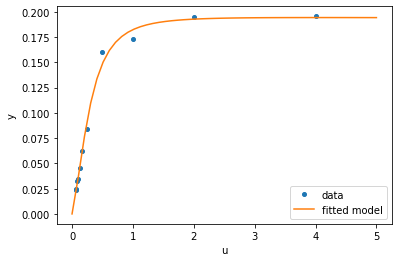

In [14]:
import matplotlib.pyplot as plt
u_test = np.linspace(0, 5)
y_test = model(res.x, u_test)
plt.plot(u, y, 'o', markersize=4, label='data')
plt.plot(u_test, y_test, label='fitted model')
plt.xlabel("u")
plt.ylabel("y")
plt.legend(loc='lower right')
plt.show()

### Univariate function minimizers (minimize_scalar)

Often only the minimum of an univariate function (i.e., a function that takes a scalar as input) is needed. In these circumstances, other optimization techniques have been developed that can work faster. These are accessible from the minimize_scalar function, which proposes several algorithms.

#### Unconstrained minimization (method='brent')

There are, actually, two methods that can be used to minimize an univariate function: `brent` and *golden*, but golden is included only for academic purposes and should rarely be used. These can be respectively selected through the method parameter in minimize_scalar. The `brent` method uses Brent's algorithm for locating a minimum. Optimally, a bracket (the `bracket` parameter) should be given which contains the minimum desired. A bracket is a triple $(a, b, c)$ such that $f(a)>f(b)< f(c)$ and $a< b < c$. If this is not given, then alternatively two starting points can be chosen and a bracket will be found from these points using a simple marching algorithm. If these two starting points are not provided, 0 and 1 will be used (this may not be the right choice for your function and result in an unexpected minimum being returned).
Here is an example:

In [15]:
from scipy.optimize import minimize_scalar
f = lambda x: (x - 2) * (x + 1)**2
res = minimize_scalar(f, method='brent')
print(res.x)


1.0


### Global optimization

Global optimization aims to find the global minimum of a function within given bounds, in the presence of potentially many local minima. Typically, global minimizers efficiently search the parameter space, while using a local minimizer (e.g., `minimize`) under the hood. SciPy contains a number of good global optimizers. Here, we’ll use those on the same objective function, namely the (aptly named) `eggholder` function:

In [16]:
def eggholder(x):
    return (-(x[1] + 47) * np.sin(np.sqrt(abs(x[0]/2 + (x[1]  + 47))))-x[0] * np.sin(np.sqrt(abs(x[0] - (x[1]  + 47)))))
bounds = [(-512, 512), (-512, 512)]

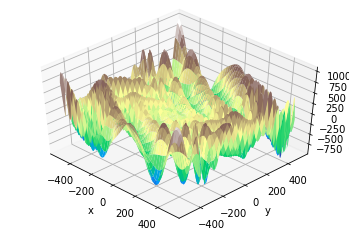

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.arange(-512, 513)
y = np.arange(-512, 513)
xgrid, ygrid = np.meshgrid(x, y)
xy = np.stack([xgrid, ygrid])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45, -45)
ax.plot_surface(xgrid, ygrid, eggholder(xy), cmap='terrain')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('eggholder(x, y)')
plt.show()

We now use the global optimizers to obtain the minimum and the function value at the minimum. We’ll store the results in a dictionary so we can compare different optimization results later.

In [18]:
from scipy import optimize
results = dict()
results['shgo'] = optimize.shgo(eggholder, bounds)
results['shgo']

     fun: -935.3379515605128
    funl: array([-935.33795156])
 message: 'Optimization terminated successfully.'
    nfev: 55
     nit: 2
   nlfev: 50
   nlhev: 0
   nljev: 10
 success: True
       x: array([439.48097806, 453.97741934])
      xl: array([[439.48097806, 453.97741934]])

In [19]:
results['DA'] = optimize.dual_annealing(eggholder, bounds)
results['DA']

     fun: -888.9491252686962
 message: ['Maximum number of iteration reached']
    nfev: 4079
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([347.32688546, 499.41533776])

All optimizers return an `OptimizeResult`, which in addition to the solution contains information on the number of function evaluations, whether the optimization was successful, and more. For brevity, we won’t show the full output of the other optimizers:

In [20]:
results['DE'] = optimize.differential_evolution(eggholder, bounds)
results['BH'] = optimize.basinhopping(eggholder, bounds)

In [21]:
results['shgo_sobol'] = optimize.shgo(eggholder, bounds, n=200, iters=5, sampling_method='sobol')

We’ll now plot all found minima on a heatmap of the function:



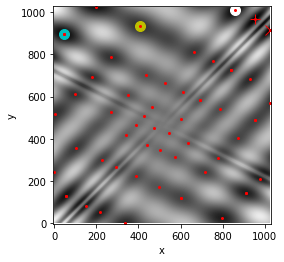

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(eggholder(xy), interpolation='bilinear', origin='lower',
              cmap='gray')
ax.set_xlabel('x')
ax.set_ylabel('y')

def plot_point(res, marker='o', color=None):
    ax.plot(512+res.x[0], 512+res.x[1], marker=marker, color=color, ms=10)

plot_point(results['BH'], color='y')  # basinhopping           - yellow
plot_point(results['DE'], color='c')  # differential_evolution - cyan
plot_point(results['DA'], color='w')  # dual_annealing.        - white

# SHGO produces multiple minima, plot them all (with a smaller marker size)
plot_point(results['shgo'], color='r', marker='+')
plot_point(results['shgo_sobol'], color='r', marker='x')
for i in range(results['shgo_sobol'].xl.shape[0]):
    ax.plot(512 + results['shgo_sobol'].xl[i, 0],
            512 + results['shgo_sobol'].xl[i, 1],
            'ro', ms=2)

ax.set_xlim([-4, 514*2])
ax.set_ylim([-4, 514*2])
plt.show()